In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
def preprocess_images(images):
    return images.astype('float32') / 255.0  # Normalize images to [0, 1]

# Load MNIST dataset
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=None)

x_train = preprocess_images(mnist_train.data.numpy())
x_test = preprocess_images(mnist_test.data.numpy())



Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.29MB/s]


In [2]:
# Add noise to the images
def add_noise(images, noise_factor=0.5):
    noisy_images = images + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=images.shape)
    return np.clip(noisy_images, 0., 1.)  # Clip values to [0, 1]

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)

# Flatten the images
x_train_noisy_flat = x_train_noisy.reshape(-1, 28 * 28)
x_test_noisy_flat = x_test.reshape(-1, 28 * 28)
x_train_flat = x_train.reshape(-1, 28 * 28)
x_test_flat = x_test.reshape(-1, 28 * 28)

# Convert to PyTorch tensors
x_train_noisy_tensor = torch.FloatTensor(x_train_noisy_flat)
x_train_tensor = torch.FloatTensor(x_train_flat)
x_test_noisy_tensor = torch.FloatTensor(x_test_noisy_flat)
x_test_tensor = torch.FloatTensor(x_test_flat)

# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_noisy_tensor, x_train_tensor)
test_dataset = TensorDataset(x_test_noisy_tensor, x_test_tensor)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)




In [3]:
# Define the autoencoder model
class SimpleAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(SimpleAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, encoding_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, input_dim),
            nn.Sigmoid()  # Output values between [0, 1]
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Model parameters
input_dim = 28 * 28  # Input image size (flattened)
encoding_dim = 128   # Dimensionality of the encoding layer

# Initialize the model
model = SimpleAutoencoder(input_dim, encoding_dim).to(device)
print(model)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# Training function
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    train_loss = 0
    for noisy_imgs, clean_imgs in train_loader:
        noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)

        # Forward pass
        outputs = model(noisy_imgs)
        loss = criterion(outputs, clean_imgs)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return train_loss / len(train_loader)

# Validation function
def validate(model, test_loader, criterion, device):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for noisy_imgs, clean_imgs in test_loader:
            noisy_imgs, clean_imgs = noisy_imgs.to(device), clean_imgs.to(device)
            outputs = model(noisy_imgs)
            loss = criterion(outputs, clean_imgs)
            val_loss += loss.item()

    return val_loss / len(test_loader)

# Training loop
num_epochs = 50
train_losses = []
val_losses = []



SimpleAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


Epoch [1/50], Train Loss: 0.0503, Val Loss: 0.0772
Epoch [2/50], Train Loss: 0.0261, Val Loss: 0.0688
Epoch [3/50], Train Loss: 0.0209, Val Loss: 0.0645
Epoch [4/50], Train Loss: 0.0187, Val Loss: 0.0617
Epoch [5/50], Train Loss: 0.0175, Val Loss: 0.0578
Epoch [6/50], Train Loss: 0.0169, Val Loss: 0.0558
Epoch [7/50], Train Loss: 0.0164, Val Loss: 0.0525
Epoch [8/50], Train Loss: 0.0161, Val Loss: 0.0499
Epoch [9/50], Train Loss: 0.0159, Val Loss: 0.0465
Epoch [10/50], Train Loss: 0.0157, Val Loss: 0.0436
Epoch [11/50], Train Loss: 0.0155, Val Loss: 0.0398
Epoch [12/50], Train Loss: 0.0154, Val Loss: 0.0375
Epoch [13/50], Train Loss: 0.0153, Val Loss: 0.0344
Epoch [14/50], Train Loss: 0.0152, Val Loss: 0.0310
Epoch [15/50], Train Loss: 0.0151, Val Loss: 0.0289
Epoch [16/50], Train Loss: 0.0151, Val Loss: 0.0261
Epoch [17/50], Train Loss: 0.0150, Val Loss: 0.0233
Epoch [18/50], Train Loss: 0.0149, Val Loss: 0.0210
Epoch [19/50], Train Loss: 0.0149, Val Loss: 0.0198
Epoch [20/50], Train 

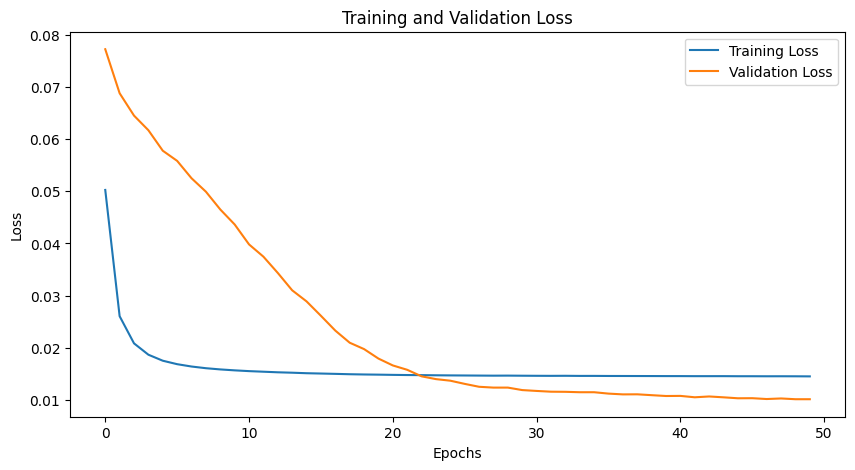

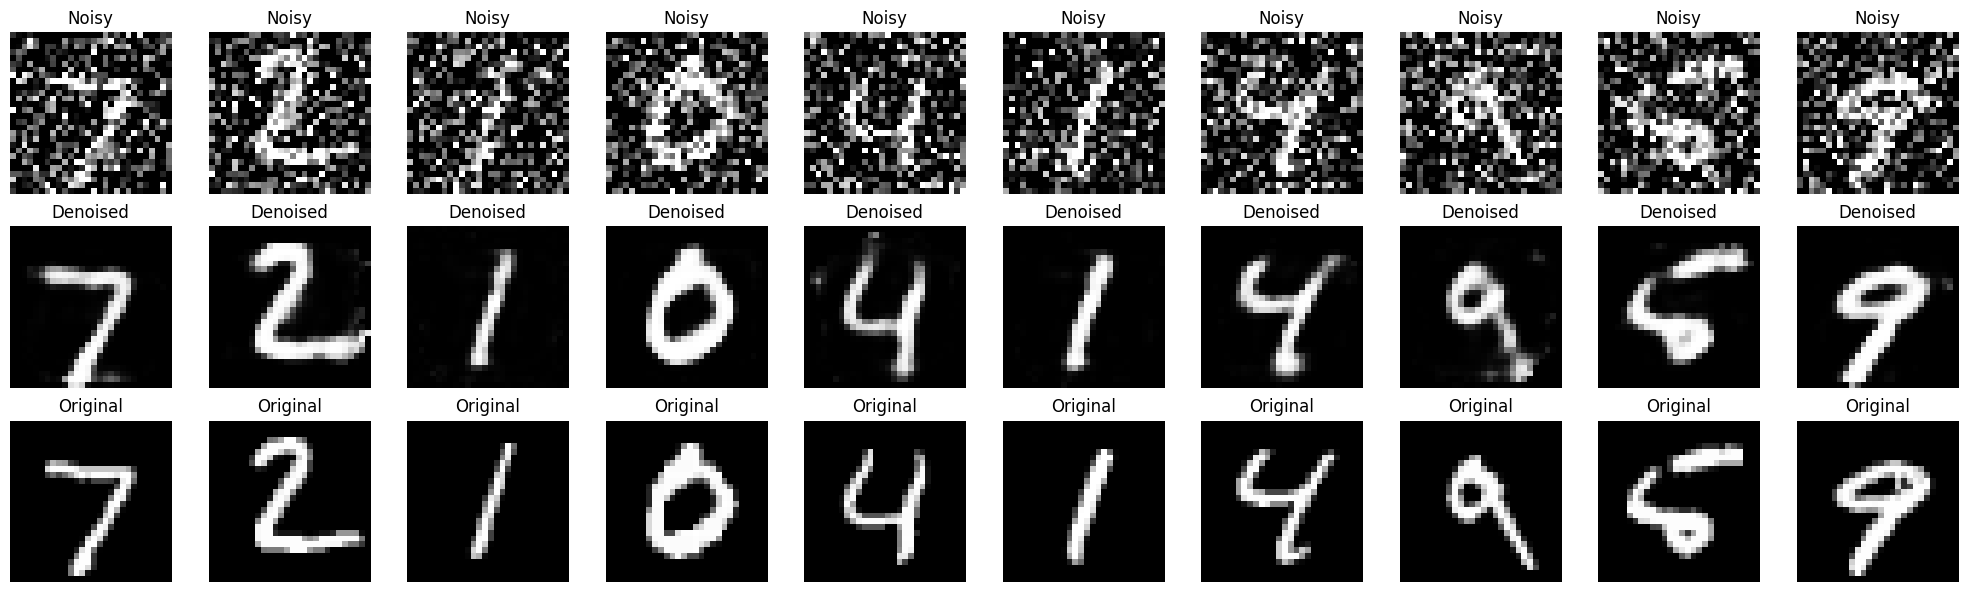

In [4]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Visualize results
model.eval()
with torch.no_grad():
    # Get a batch of test images
    test_noisy_batch = x_test_noisy_tensor[:10].to(device)
    decoded_imgs = model(test_noisy_batch).cpu().numpy()

# Reshape images for visualization
decoded_imgs = decoded_imgs.reshape(-1, 28, 28)
x_test_noisy_display = x_test_noisy[:10]
x_test_display = x_test[:10]

# Visualize results
n = 10  # Number of images to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display noisy images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy_display[i], cmap='gray')
    plt.title("Noisy")
    plt.axis('off')

    # Display denoised images
    ax = plt.subplot(3, n, i + n + 1)
    plt.imshow(decoded_imgs[i], cmap='gray')
    plt.title("Denoised")
    plt.axis('off')

    # Display ground truth
    ax = plt.subplot(3, n, i + 2 * n + 1)
    plt.imshow(x_test_display[i], cmap='gray')
    plt.title("Original")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Compute performance metrics: MSE, SSIM, CC
def evaluate_performance(original, denoised):
    mse_list = []
    ssim_list = []
    cc_list = []

    for orig_img, denoised_img in zip(original, denoised):
        # Flatten images for MSE and CC computation
        orig_img_flat = orig_img.flatten()
        denoised_img_flat = denoised_img.flatten()

        # Compute MSE
        mse = mean_squared_error(orig_img_flat, denoised_img_flat)
        mse_list.append(mse)

        # Compute SSIM
        ssim_val = ssim(orig_img.squeeze(), denoised_img.squeeze(), data_range=1.0)
        ssim_list.append(ssim_val)

        # Compute Correlation Coefficient (CC)
        cc = np.corrcoef(orig_img_flat, denoised_img_flat)[0, 1]
        cc_list.append(cc)

    # Return average metrics (moved outside the loop)
    mean_mse = np.mean(mse_list)
    mean_ssim = np.mean(ssim_list)
    mean_cc = np.mean(cc_list)

    return mean_mse, mean_ssim, mean_cc

# Calculate metrics
mse, ssim_score, cc = evaluate_performance(x_test, decoded_imgs)

# Print the results
print(f"Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Structural Similarity Index (SSIM): {ssim_score:.6f}")
print(f"Correlation Coefficient (CC): {cc:.6f}")


Performance Metrics:
Mean Squared Error (MSE): 0.008231
Structural Similarity Index (SSIM): 0.897021
Correlation Coefficient (CC): 0.952989


# Image debluring using simple autoencoder

Sample images:


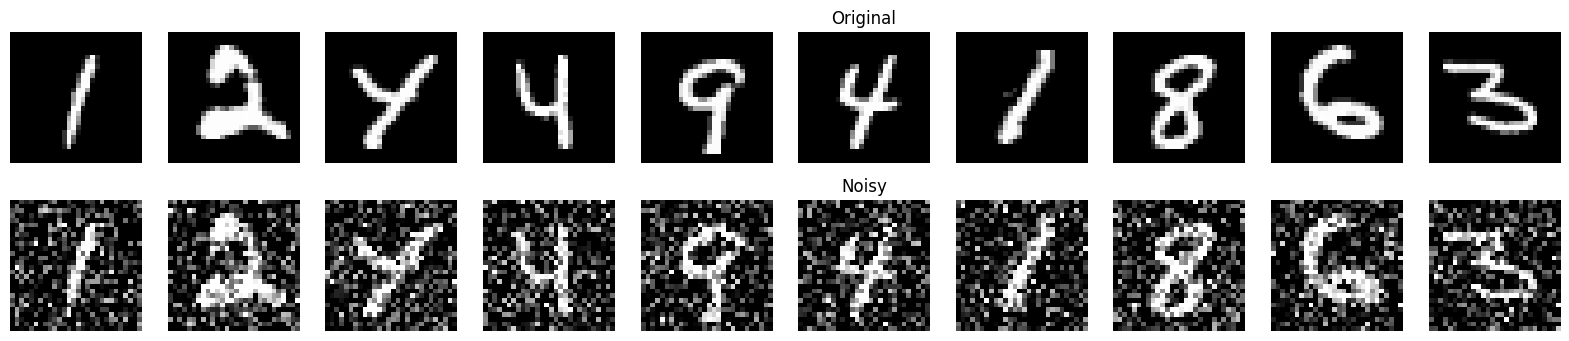

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.3067 - val_loss: 0.1113
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1073 - val_loss: 0.1011
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0996 - val_loss: 0.0979
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0965 - val_loss: 0.0959
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0946 - val_loss: 0.0943
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0933 - val_loss: 0.0930
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0923 - val_loss: 0.0920
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0912 - val_loss: 0.0912
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0905 - val_loss: 0.0910
Epoch 10/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0900 - val_loss: 0.0901
Epoch 11/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0894 - val_loss: 0.0897
Epoch 12/100
375/375 ━━━━━━━━━━━━━━━━━━━

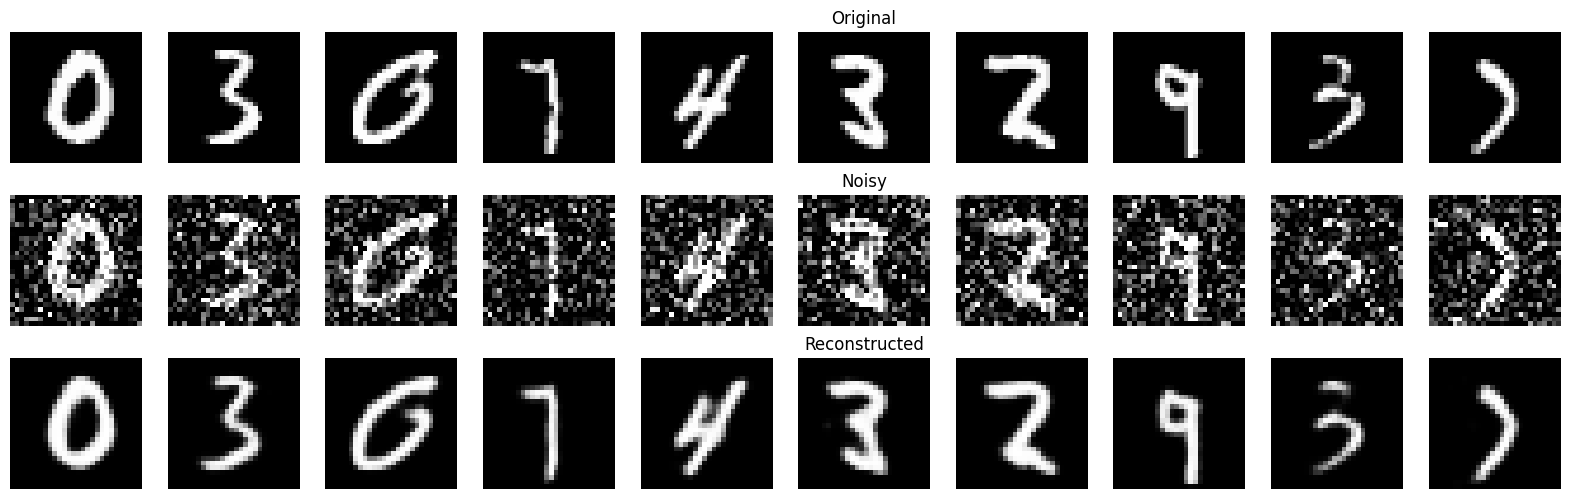

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.datasets import mnist
from keras.models import Model
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Data preprocessing functions
def preprocess(array):
    array = array.astype("float32") / 255.0
    return np.reshape(array, (len(array), 28, 28, 1))

# Add noise to images
def add_noise(array, noise_factor=0.4):
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

# Display original and noisy images
def display_images(original, noisy, decoded=None, n=10):
    plt.figure(figsize=(20, 6 if decoded is not None else 4))
    indices = np.random.randint(len(original), size=n)

    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3 if decoded is not None else 2, n, i + 1)
        plt.imshow(original[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == n // 2:
            ax.set_title('Original')

        # Noisy images
        ax = plt.subplot(3 if decoded is not None else 2, n, i + 1 + n)
        plt.imshow(noisy[idx].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == n // 2:
            ax.set_title('Noisy')

        # Decoded images (optional)
        if decoded is not None:
            ax = plt.subplot(3, n, i + 1 + 2 * n)
            plt.imshow(decoded[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')
            if i == n // 2:
                ax.set_title('Reconstructed')

    plt.show()

# Load and preprocess data
(x_train, _), (x_test, _) = mnist.load_data()
x_train = preprocess(x_train)
x_test = preprocess(x_test)

# Generate noisy data
noisy_x_train = add_noise(x_train)
noisy_x_test = add_noise(x_test)

# Display images
print("Sample images:")
display_images(x_train, noisy_x_train)

# Define the convolutional autoencoder
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Compile the model
autoencoder = Model(input_img, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

# Train the autoencoder
autoencoder.fit(noisy_x_train, x_train, epochs=100, batch_size=128, validation_split=0.2, shuffle=True)

# Generate reconstructed images
decoded_imgs = autoencoder.predict(noisy_x_test)

# Evaluate performance metrics
def evaluate_performance(true_imgs, pred_imgs):
    true_imgs_flat = true_imgs.reshape(len(true_imgs), -1)
    pred_imgs_flat = pred_imgs.reshape(len(pred_imgs), -1)

    mse = mean_squared_error(true_imgs_flat, pred_imgs_flat)
    ssim_score = np.mean([ssim(true_imgs[i].squeeze(), pred_imgs[i].squeeze(), data_range=1.0)
                          for i in range(len(true_imgs))])
    cc = np.corrcoef(true_imgs_flat.flatten(), pred_imgs_flat.flatten())[0, 1]

    return mse, ssim_score, cc

mse, ssim_score, cc = evaluate_performance(x_test, decoded_imgs)

# Print performance metrics
print(f"Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Structural Similarity Index (SSIM): {ssim_score:.6f}")
print(f"Correlation Coefficient (CC): {cc:.6f}")

# Display reconstructed images
print("Reconstructed images:")
display_images(x_test, noisy_x_test, decoded_imgs)

# Convolutional Autoencoder for image denoising

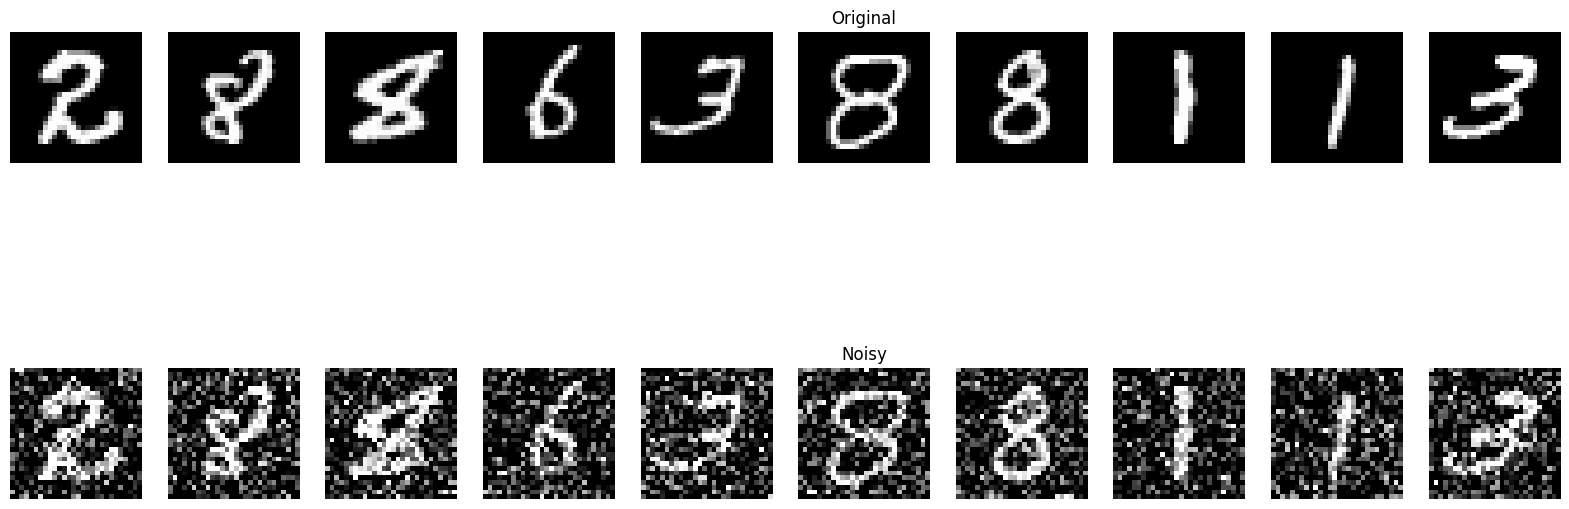

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_8 (Conv2DTranspose) │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_9 (Conv2DTranspose) │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.3103 - val_loss: 0.1073
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1035 - val_loss: 0.0986
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0974 - val_loss: 0.0958
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0946 - val_loss: 0.0943
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0932 - val_loss: 0.0929
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0923 - val_loss: 0.0923
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0911 - val_loss: 0.0912
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0904 - val_loss: 0.0905
Epoch 9/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0896 - val_loss: 0.0900
Epoch 10/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0892 - val_loss: 0.0895
Epoch 11/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0888 - val_loss: 0.0892
Epoch 12/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/ste

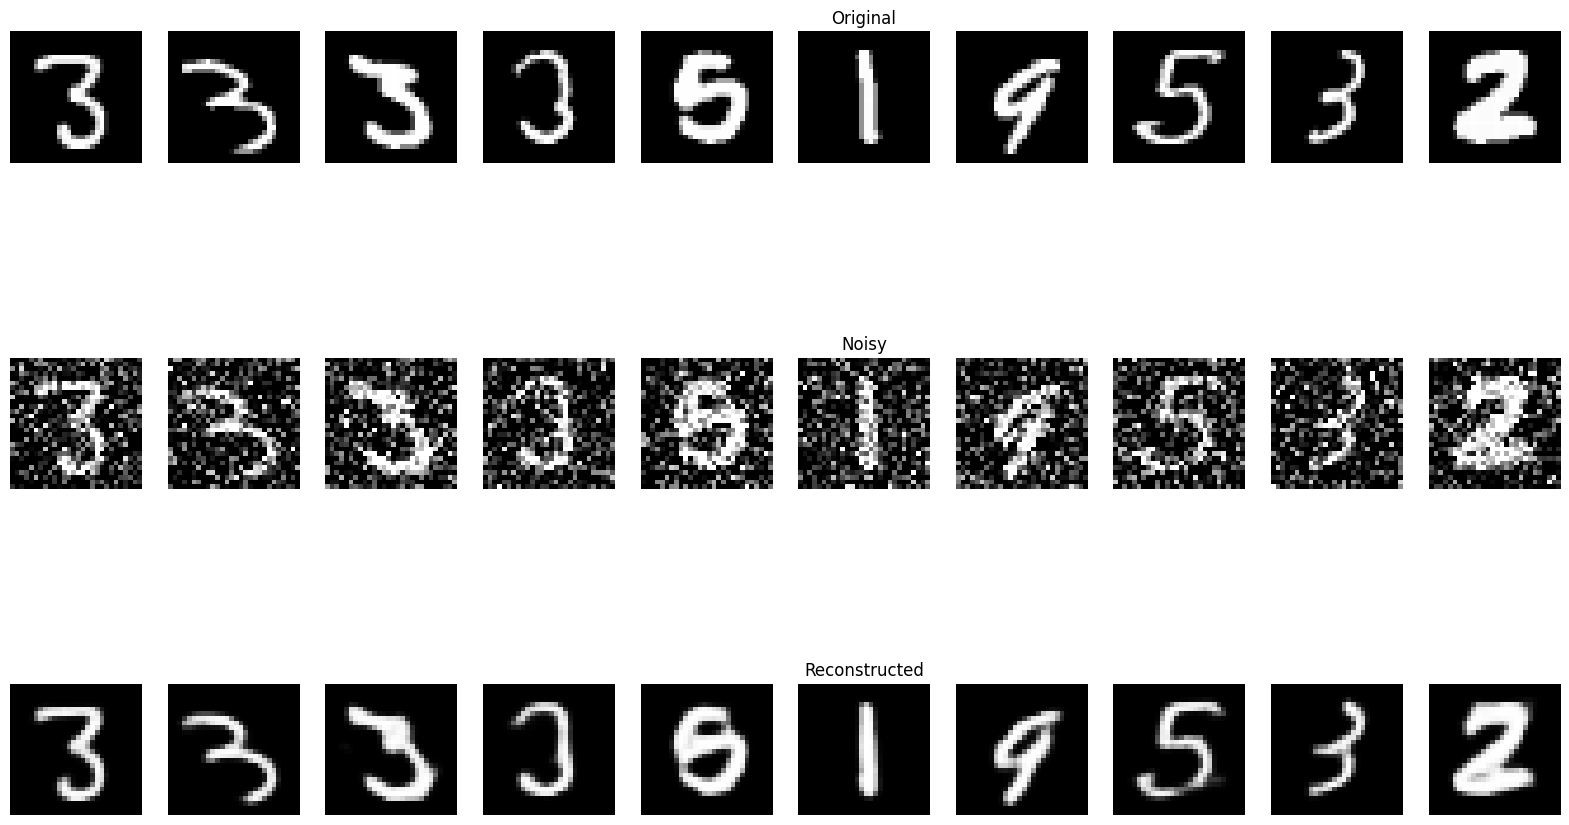

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from keras import layers
from keras.datasets import mnist
from keras.models import Model
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim

# Data preprocessing
def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array

# Add noise to data
def add_noise(array, noise_factor=0.4):
    """Adds random noise to each image in the supplied array."""
    noisy_array = array + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=array.shape)
    return np.clip(noisy_array, 0.0, 1.0)

# Display images
def display_images(original, noisy, decoded=None):
    """Displays ten random images from original, noisy, and optionally decoded arrays."""
    n = 10
    indices = np.random.randint(len(original), size=n)

    rows = 3 if decoded is not None else 2
    plt.figure(figsize=(20, 4 * rows))
    for i, idx in enumerate(indices):
        ax = plt.subplot(rows, n, i + 1)
        plt.imshow(original[idx].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == n // 2:
            ax.set_title('Original')

        ax = plt.subplot(rows, n, i + 1 + n)
        plt.imshow(noisy[idx].reshape(28, 28), cmap='gray')
        ax.axis('off')
        if i == n // 2:
            ax.set_title('Noisy')

        if decoded is not None:
            ax = plt.subplot(rows, n, i + 1 + 2 * n)
            plt.imshow(decoded[idx].reshape(28, 28), cmap='gray')
            ax.axis('off')
            if i == n // 2:
                ax.set_title('Reconstructed')
    plt.show()

# Load MNIST data
(train_data, _), (test_data, _) = mnist.load_data()

# Preprocess data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Generate noisy data
noisy_train_data = add_noise(train_data)
noisy_test_data = add_noise(test_data)

# Display sample images
display_images(train_data, noisy_train_data)

# Define the Convolutional Autoencoder (CAE)
input_img = layers.Input(shape=(28, 28, 1))

# Encoder
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input_img)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Model compilation
CAE = Model(input_img, x)
CAE.compile(optimizer="adam", loss="binary_crossentropy")
CAE.summary()

# Train the autoencoder
CAE.fit(noisy_train_data, train_data, epochs=20, batch_size=128, validation_split=0.2, shuffle=True)

# Generate reconstructed images
decoded_imgs = CAE.predict(noisy_test_data)

# Evaluate performance metrics
def evaluate_performance(true_imgs, pred_imgs):
    true_imgs_flat = true_imgs.reshape(len(true_imgs), -1)
    pred_imgs_flat = pred_imgs.reshape(len(pred_imgs), -1)

    mse = mean_squared_error(true_imgs_flat, pred_imgs_flat)
    ssim_score = np.mean([ssim(true_imgs[i].squeeze(), pred_imgs[i].squeeze(), data_range=1.0)
                          for i in range(len(true_imgs))])
    cc = np.corrcoef(true_imgs_flat.flatten(), pred_imgs_flat.flatten())[0, 1]

    return mse, ssim_score, cc

mse, ssim_score, cc = evaluate_performance(test_data, decoded_imgs)

# Print performance metrics
print("Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Structural Similarity Index (SSIM): {ssim_score:.6f}")
print(f"Correlation Coefficient (CC): {cc:.6f}")

# Display reconstructed images
display_images(test_data, noisy_test_data, decoded_imgs)


# Sparse Autoencoder

Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.3035 - val_loss: 0.1338
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1094 - val_loss: 0.0990
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0792 - val_loss: 0.0871
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0658 - val_loss: 0.0786
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0591 - val_loss: 0.0756
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0540 - val_loss: 0.0754
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0516 - val_loss: 0.0712
Epoch 8/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0479 - val_loss: 0.0716
Epoch 9/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0467 - val_loss: 0.0685
Epoch 10/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0451 - val_loss: 0.0695
Epoch 11/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0447 - val_loss: 0.0693
Epoch 12/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/ste

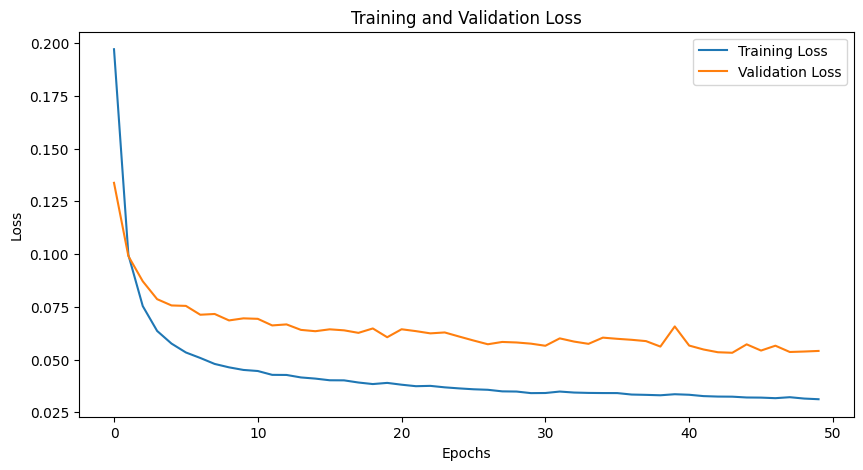

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
x_train = x_train.reshape((x_train.shape[0], -1)).astype('float32') / 255.0
x_test = x_test.reshape((x_test.shape[0], -1)).astype('float32') / 255.0

# Define hyperparameters
input_dim = 784
hidden_dim = 100
sparsity_level = 0.05
lambda_sparse = 0.1

# Define the autoencoder model
inputs = layers.Input(shape=(input_dim,))
encoded = layers.Dense(hidden_dim, activation='relu')(inputs)
decoded = layers.Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = keras.Model(inputs, decoded)
encoder = keras.Model(inputs, encoded)

# Define sparse loss function
def sparse_loss(y_true, y_pred):
    mse_loss = tf.reduce_mean(tf.keras.losses.mse(y_true, y_pred))

    hidden_layer_output = encoder(y_true)
    mean_activation = tf.reduce_mean(hidden_layer_output, axis=0)

    kl_divergence = tf.reduce_sum(
        sparsity_level * tf.math.log(sparsity_level / (mean_activation + 1e-10)) +
        (1 - sparsity_level) * tf.math.log((1 - sparsity_level) / (1 - mean_activation + 1e-10))
    )

    return mse_loss + lambda_sparse * kl_divergence



# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss=sparse_loss)

# Train the autoencoder
history = autoencoder.fit(
    x_train, x_train,
    validation_split=0.2,
    epochs=50,
    batch_size=256,
    shuffle=True
)

# Plot training and validation loss
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


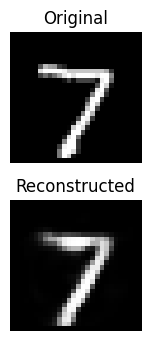

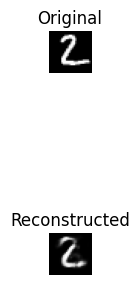

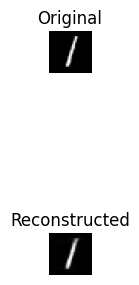

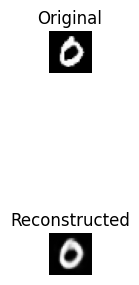

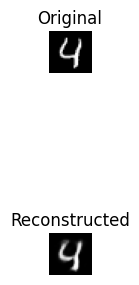

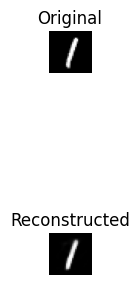

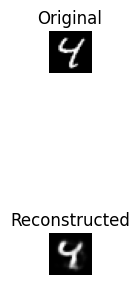

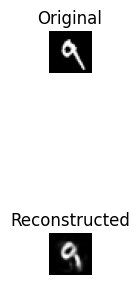

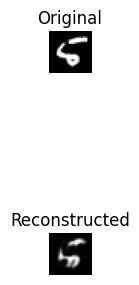

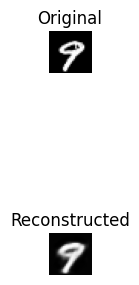

In [16]:
reconstructed = autoencoder.predict(x_test)
# Visualize original vs. reconstructed images
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
  # Original images
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
  plt.title("Original")
  plt.axis('off')
  # Reconstructed images
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
  plt.title("Reconstructed")
  plt.axis('off')
  plt.show()

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


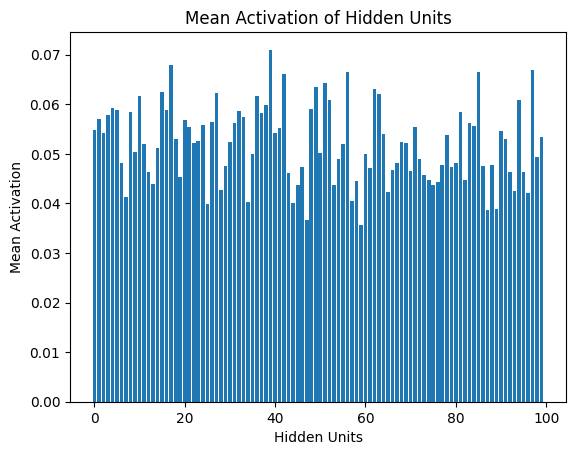

In [17]:
encoded_outputs = encoder.predict(x_train)
mean_activation = np.mean(encoded_outputs, axis=0)
plt.bar(range(len(mean_activation)), mean_activation)
plt.title("Mean Activation of Hidden Units")
plt.xlabel("Hidden Units")
plt.ylabel("Mean Activation")
plt.show()

In [18]:
encoded_outputs[1]

array([0.        , 0.        , 0.        , 0.5211561 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03829347, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.44165885,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05025293,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.1987564 , 0.        , 0.        , 0.46224487, 0.        ,
       0.        , 0.17286909, 0.16208342, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.8634981 , 0.05673125, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     